<a href="https://colab.research.google.com/github/0422alsrud/ml/blob/master/MLP_Mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
from torch import nn
!pip install einops
from einops.layers.torch import Rearrange
import glob
import cv2
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/imagenet-mini')
os.listdir()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


['val', 'train', 'data']

In [3]:

class customDataset(Dataset):
    def __init__(self):
        self.imags_path = '/content/drive/MyDrive/imagenet-mini/train'      
        file_list = glob.glob(self.imags_path + '*')
        print(file_list)
        self.data = []

        
        for class_path in file_list:
            class_name = class_path.split('/')[-1]
            print(class_name)
            for img_path in glob.glob(class_path + '/*.jpeg'):
                self.data.append([img_path,class_name])
                print(self.data)
        # self.class_map = {'dogs':0, 'cats':1}
        self.img_dim = (416,416)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_path,class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img,self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

dataset = customDataset()
print(dataset)

['/content/drive/MyDrive/imagenet-mini/train']
train


In [4]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):

    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )

    def forward(self, x):

        x = x + self.token_mix(x)

        x = x + self.channel_mix(x)

        return x


class MLPMixer(nn.Module):

    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, token_dim, channel_dim):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size // patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, patch_size, patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, self.num_patch, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):

        x = self.to_patch_embedding(x)

        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x = self.layer_norm(x)

        x = x.mean(dim=1)

        return self.mlp_head(x)


# if __name__ == '__main__':

#     dataset = customDataset()
#     train_loader = DataLoader(dataset,batch_size=1,shuffle=True)

#     mixer_model = MLPMixer(in_channels=3, 
#         image_size=416, 
#         patch_size=16, 
#         num_classes=2,
#         dim=512, 
#         depth=8, 
#         token_dim=256, 
#         channel_dim=2048)

#     for i, data in enumerate(train_loader,0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         inputs, labels = inputs.float(), labels.float()
#         outputs = mixer_model(inputs)

In [5]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


truck  deer plane  ship


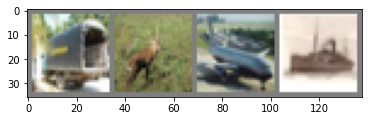

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
##이거수정해봐봐바ㅏ밥


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# net = MLPMixer()
net = MLPMixer(in_channels=3, 
         image_size=32, 
         patch_size=16, 
         num_classes=10,
         dim=512, 
         depth=8, 
         token_dim=256, 
         channel_dim=2048)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.860
[1,  4000] loss: 1.645
[1,  6000] loss: 1.535


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))